In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import importlib

keras = tf.keras
tf.enable_eager_execution()

import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "../src")

In [17]:
from euler import fwd_tlist, fwd_sde_tlist
importlib.reload(sys.modules['euler'])
import models as md
importlib.reload(sys.modules['models'])
import training as tr
importlib.reload(sys.modules['training'])
from utilities import rand_batch, tile_batch
importlib.reload(sys.modules['utilities'])

<module 'utilities' from '../src/utilities.py'>

# Van der Pol Oscillator

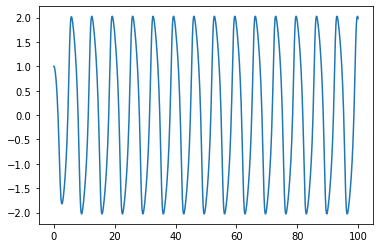

In [3]:
time_steps = 1000
t_free = np.linspace(0, 100, time_steps)
y0 = tf.cast([[1.0], [0.]], tf.float32)
model = md.VDPOscillator()

free_trajectory = fwd_tlist(model, y0, t_free, 1e-2)
free_trajectory = np.concatenate(free_trajectory[:,0,0])

plt.plot(t_free,free_trajectory)
plt.show()

# Controlled Van der Pol Oscillator

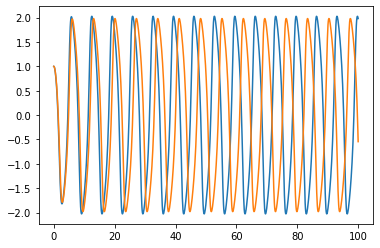

In [4]:
time_steps = 1000
t_grid = np.linspace(0, 100, time_steps)
y0 = tf.cast([[1.0], [0.]], tf.float32)
model = md.VDPOscillatorNNControl()

trajectory = fwd_tlist(model, y0, t_grid, 1e-2)
trajectory = np.concatenate(trajectory[:,0,0])

plt.plot(t_free,free_trajectory, t_grid,trajectory)
plt.show()

# Train

In [5]:
def train_ode(model, batch_size, niters, test_freq, t_grid, free_trajectory):
    y0 = tf.cast([[[1.], [0.]]],tf.float32)

    optimizer = tf.train.MomentumOptimizer(learning_rate=1e-2, momentum=0.5)
    
    loss_history = []

    for step in range(niters+1):
    
        # batch_y0 = rand_batch(batch_size) # Random
        batch_y0 = tile_batch(batch_size, y0) # Fixed

        loss = tr.gradient_update(model, fwd_tlist, optimizer, batch_y0, t_grid)
   
        loss_history.append(loss.numpy())

        if step % test_freq == 0:
            trajectory = fwd_tlist(model, y0, t_grid, 1e-2)
            print(loss)

            trajectory = np.concatenate(trajectory[:,0,0])
            plt.plot(t_grid,free_trajectory, t_grid,trajectory)
            plt.legend( ('free oscillator', 'controlled oscillator/system'))
            plt.show()

    return loss_history

In [6]:
def train_sde(model, batch_size, niters, test_freq, t_grid, free_trajectory):
    y0 = tf.cast([[[1.], [0.]]],tf.float32)

    optimizer = tf.train.MomentumOptimizer(learning_rate=1e-2, momentum=0.5)
    
    loss_history = []

    for step in range(niters+1):
    
        # batch_y0 = rand_batch(batch_size) # Random
        batch_y0 = tile_batch(batch_size, y0) # Fixed

        loss = tr.gradient_update(model, fwd_sde_tlist, optimizer, batch_y0, t_grid)
   
        loss_history.append(loss.numpy())

        if step % test_freq == 0:
            trajectory = fwd_sde_tlist(model, y0, t_grid, 1e-2)        
            print(loss)

            trajectory = np.concatenate(trajectory[:,0,0])
            plt.plot(t_grid,free_trajectory, t_grid,trajectory)
            plt.legend( ('free oscillator', 'controlled oscillator/system'))
            plt.show()

    return loss_history

## ODE system

In [9]:
# Set up parameters
time_steps = 50
t_grid = np.linspace(0, 30, time_steps)

# Free system for comparison
free_trajectory = fwd_tlist(md.VDPOscillator(), y0, t_grid, 1e-2)
free_trajectory = np.concatenate(free_trajectory[:,0,0])

# Initialise new instance of the model
model = md.VDPOscillatorNNControl()

tf.Tensor([2.3906746], shape=(1,), dtype=float32)


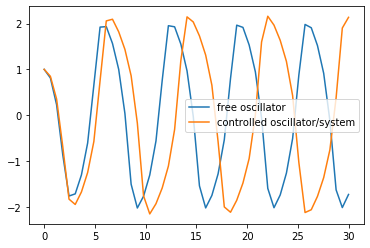

tf.Tensor([0.14489241], shape=(1,), dtype=float32)


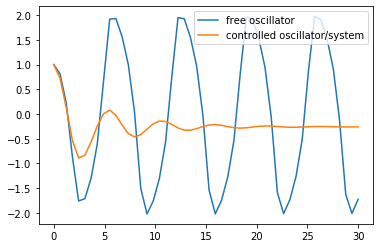

tf.Tensor([0.04805425], shape=(1,), dtype=float32)


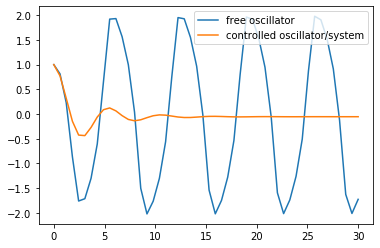

tf.Tensor([0.04022215], shape=(1,), dtype=float32)


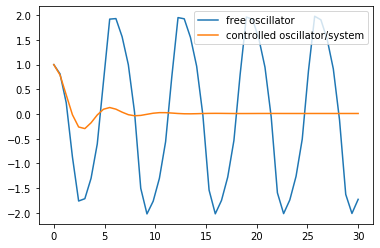

In [10]:
batch_size = 5
niters = 60
test_freq = 20

loss_history = train_ode(model, batch_size, niters, test_freq, t_grid, free_trajectory)

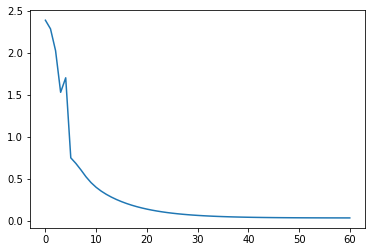

In [11]:
plt.plot(loss_history)

## SDE system

In [18]:
# Set up parameters
time_steps = 50
t_grid = np.linspace(0, 30, time_steps)

# Free system for comparison
free_trajectory = fwd_sde_tlist(md.VDPOscillator(), y0, t_grid, 1e-2)
free_trajectory = np.concatenate(free_trajectory[:,0,0])

# Initialise new instance of the model
sde_model = md.VDPOscillatorNNControl()

tf.Tensor([1.9066422], shape=(1,), dtype=float32)


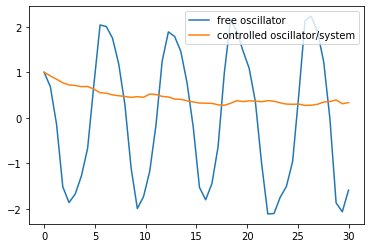

tf.Tensor([0.09236309], shape=(1,), dtype=float32)


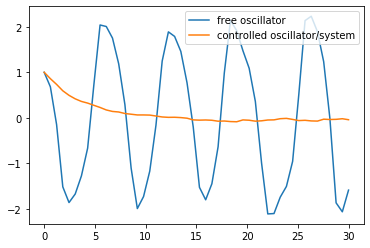

tf.Tensor([0.08341894], shape=(1,), dtype=float32)


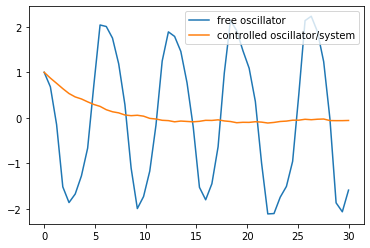

tf.Tensor([0.07809853], shape=(1,), dtype=float32)


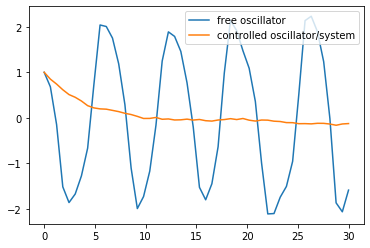

In [19]:
batch_size = 5
niters = 30
test_freq = 10

loss_history = train_sde(sde_model, batch_size, niters, test_freq, t_grid, free_trajectory)

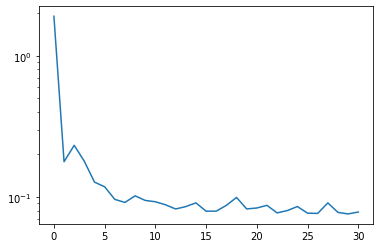

In [21]:
plt.plot(loss_history)
plt.yscale("log")